Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


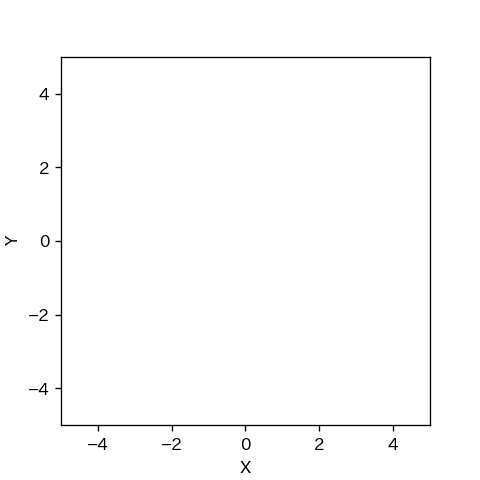

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_trap_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
#, phantom_prob=0.1
    world.draw()
    return (r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


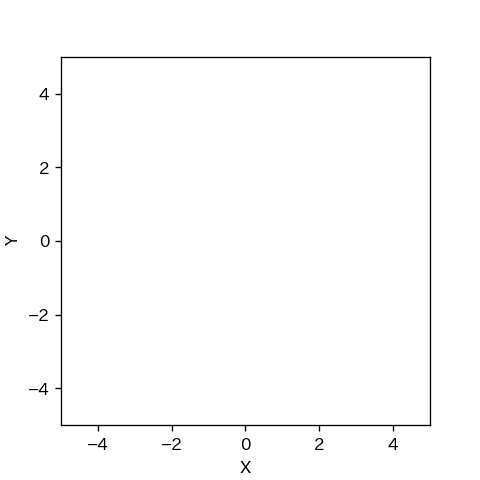

(array([0.82870256, 1.89497768, 0.05399001]),
 array([3.41578002, 2.95294404, 2.74688172]))

In [4]:
trial_trap_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_trap_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[2.7001310316454186]
0 真値: [ 3.33069277 -2.57334115  3.43877776] 推定値: [ 3.24696656 -2.52973349 -2.77207713] 誤差: 0.0944018393093162
1
[3.657439334150938]
1 真値: [ 0.35006479 -0.3750803   3.74989253] 推定値: [-1.29862671  5.87978569  5.23294009] 誤差: 6.468503087880729
2 真値: [4.88512058 2.07297919 0.75602609] 推定値: [2.07247893 5.44764776 3.28014635] 誤差: 4.393101517087577
3 真値: [-3.90563534 -6.62662191  5.84765821] 推定値: [0.20397535 5.55221131 4.99112885] 誤差: 12.85351619487674
4 真値: [ 4.43884187 -2.24485873  1.87874683] 推定値: [-0.35276071  6.50790263  5.54030606] 誤差: 9.978491202564848
[3.3830146876264884]
5 真値: [-2.18141034  2.97790327  4.9232749 ] 推定値: [0.54608953 1.06426066 1.00746353] 誤差: 3.3318588761446537
[1.1859066875057152]
6 真値: [ 3.05466924 -0.99698167  3.86214547] 推定値: [ 2.69891036 -1.0159383   4.042387  ] 誤差: 0.3562635817510791
2
[1.2428098184647123]
7 真値: [-1.86516634  4.4843686   1.53297959] 推定値: [0.44701601 4.88736357 1.37367017] 誤差: 2.3470390191630752
[3.6715487318500406]
8 真値: [-2.

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [3.93790115 6.52327977 2.79275133] 推定値: [0.62009244 0.01207458 8.8378957 ] 誤差: 7.307779943450621
[2.585472810645017]
21 真値: [ 5.88168502 -4.07791254  2.06439362] 推定値: [ 0.69381229 -0.15129641 -1.92866797] 誤差: 6.506330582437627
[0.709747715076058]
22 真値: [3.49682245 5.35945234 3.41248498] 推定値: [5.02644711 5.82650927 2.30624002] 誤差: 1.5993416741948896
[5.235142442121033]
[6.002996219443757]
[4.027815919277656, 5.796647111807642]
23 真値: [-2.68792936  0.5986561   3.12309986] 推定値: [-2.33110627  0.7805366   3.29541065] 誤差: 0.40050372655283073
6
[5.154519093032977]
24 真値: [-0.36744689 -2.10721911  6.69835517] 推定値: [-1.1395386  -2.87844088  7.0796445 ] 誤差: 1.091287598365847
[1.6118586959978995]
25 真値: [-3.48239774  1.43542007  2.37337598] 推定値: [-3.57797346  1.52993853  2.355118  ] 誤差: 0.13441896897442668
7
[4.216391388558575, 5.4189172899448765]
26 真値: [0.23423768 1.23889635 2.15308343] 推定値: [-0.04463198  1.89960773  2.35080144] 誤差: 0.7171525741238312
8
27 真値: [0.76156236 4.88595984 1.5